In [1]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import joblib
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix,precision_score,recall_score,roc_auc_score,classification_report,
f1_score,roc_curve,log_loss)

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading train data from csv file
pac= pd.read_csv('Telecom_customer_churn.csv')
pac.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


###### Performing EDA

In [3]:
# checking shape of data
pac.shape

(7043, 21)

In [4]:
# checking data information
pac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
#checking unique value in each row
pac.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [6]:
# replacing all '?' values with nan values in train and test data
pac = pac.replace(' ', np.nan)

In [7]:
# checking null value
pac.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
#dropping null value
pac.dropna(inplace=True)
#changing data type for TotalCharges column
pac['TotalCharges']=pac['TotalCharges'].astype(float)

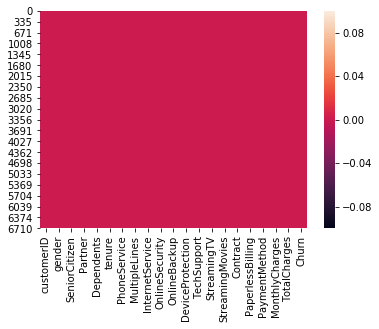

In [9]:
# heatmap of null value
sns.heatmap(pac.isnull())

In [10]:
# checking the data description
pac.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
# corelation between coloums
pac.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


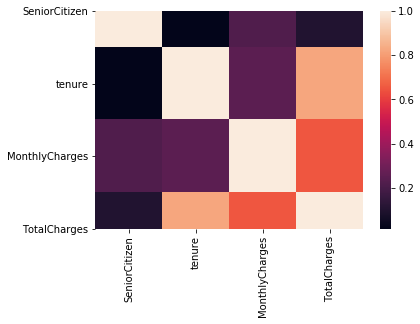

In [12]:
# heat map of corelation
sns.heatmap(pac.corr())

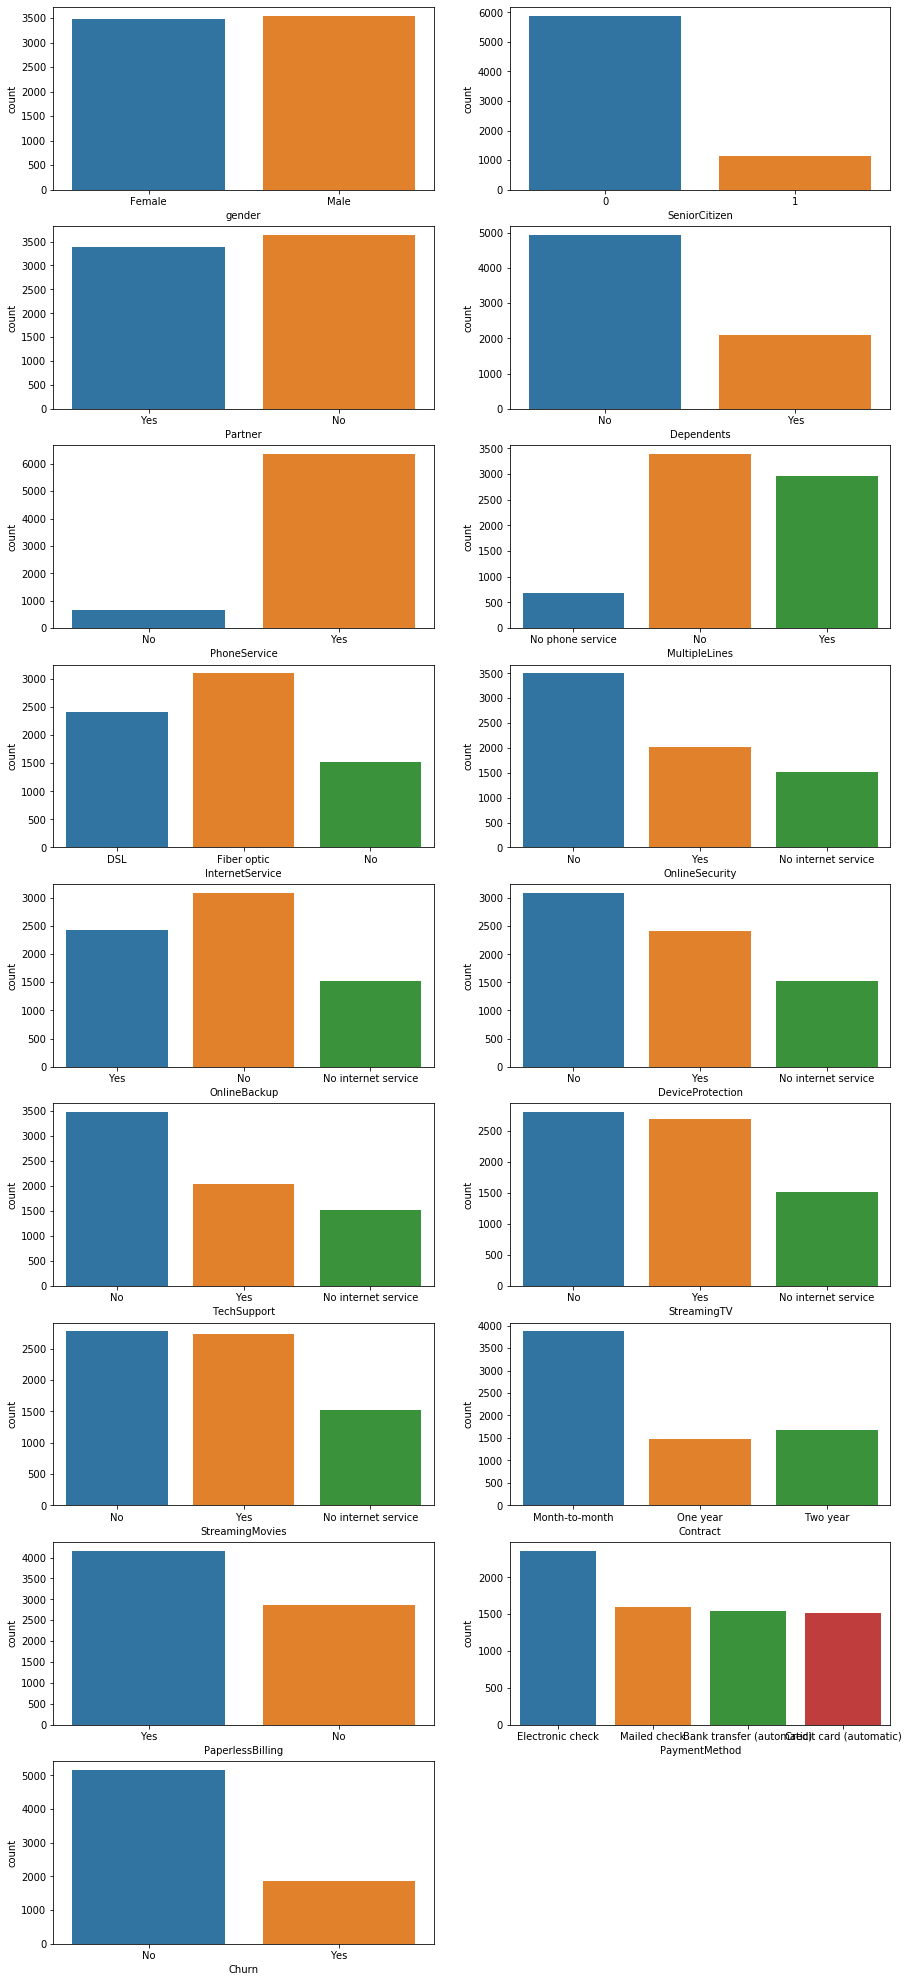

In [13]:
#creating barplot of colums to check the count of indivisual value
Index=pac[['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
           'PaymentMethod','Churn']]
figure(num=None,figsize=(15,80))
for column_index,col in enumerate(Index.columns):
    plt.subplot(20,2,column_index+1)
    sns.countplot(x=Index[col],data=Index)

In [14]:
# checking count and percentage of diffrent values in each coloums
for column_index, column in enumerate(Index.columns):
    print('\x1b[1;31m'+'Count of diffrent values in',column,'column'+'\x1b[0m')
    print(Index[column].value_counts(),'\n\n')
    print('\x1b[1;31m'+'Percentage of diffrent values in',column,'column'+'\x1b[0m')
    print(Index[column].value_counts(normalize=True),'\n\n')

Count of diffrent values in gender column
Male      3549
Female    3483
Name: gender, dtype: int64 


Percentage of diffrent values in gender column
Male      0.504693
Female    0.495307
Name: gender, dtype: float64 


Count of diffrent values in SeniorCitizen column
0    5890
1    1142
Name: SeniorCitizen, dtype: int64 


Percentage of diffrent values in SeniorCitizen column
0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64 


Count of diffrent values in Partner column
No     3639
Yes    3393
Name: Partner, dtype: int64 


Percentage of diffrent values in Partner column
No     0.517491
Yes    0.482509
Name: Partner, dtype: float64 


Count of diffrent values in Dependents column
No     4933
Yes    2099
Name: Dependents, dtype: int64 


Percentage of diffrent values in Dependents column
No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64 


Count of diffrent values in PhoneService column
Yes    6352
No      680
Name: PhoneService, dtype: int64 


Percentage of di

In [15]:
# checking count and percentage of diffrent values in each coloums over churn
for column_index, column in enumerate(Index.columns):
    print('\x1b[1;31m'+'Count of diffrent values in',column,'column'+'\x1b[0m')
    print(Index.groupby('Churn')[column].value_counts().unstack(),'\n\n')
    print('\x1b[1;31m'+'Percentage of diffrent values in',column,'column'+'\x1b[0m')
    print(Index.groupby('Churn')[column].value_counts(normalize=True).unstack(),'\n\n')

Count of diffrent values in gender column
gender  Female  Male
Churn               
No        2544  2619
Yes        939   930 


Percentage of diffrent values in gender column
gender    Female      Male
Churn                     
No      0.492737  0.507263
Yes     0.502408  0.497592 


Count of diffrent values in SeniorCitizen column
SeniorCitizen     0    1
Churn                   
No             4497  666
Yes            1393  476 


Percentage of diffrent values in SeniorCitizen column
SeniorCitizen         0         1
Churn                            
No             0.871005  0.128995
Yes            0.745318  0.254682 


Count of diffrent values in Partner column
Partner    No   Yes
Churn              
No       2439  2724
Yes      1200   669 


Percentage of diffrent values in Partner column
Partner        No       Yes
Churn                      
No       0.472400  0.527600
Yes      0.642055  0.357945 


Count of diffrent values in Dependents column
Dependents    No   Yes
Churn     

Plotting above finding for cleare understanding

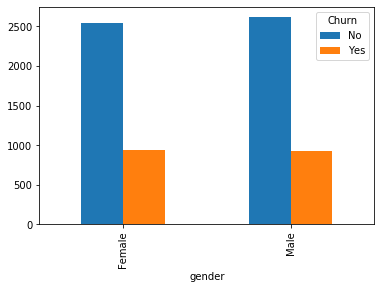

In [16]:
pac.groupby('Churn').gender.value_counts().unstack(0).plot.bar()

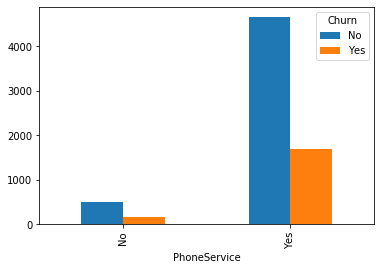

In [17]:
pac.groupby('Churn').PhoneService.value_counts().unstack(0).plot.bar()

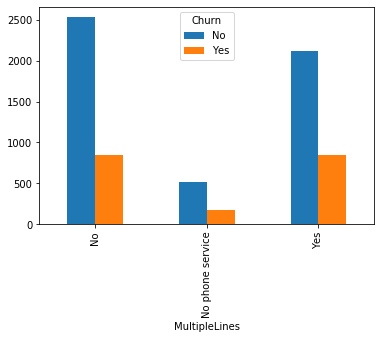

In [18]:
pac.groupby('Churn').MultipleLines.value_counts().unstack(0).plot.bar()

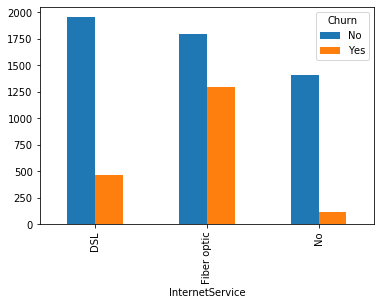

In [19]:
pac.groupby('Churn').InternetService.value_counts().unstack(0).plot.bar()

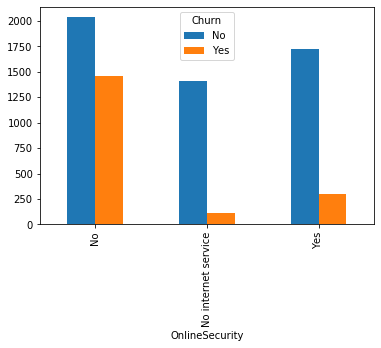

In [20]:
pac.groupby('Churn').OnlineSecurity.value_counts().unstack(0).plot.bar()

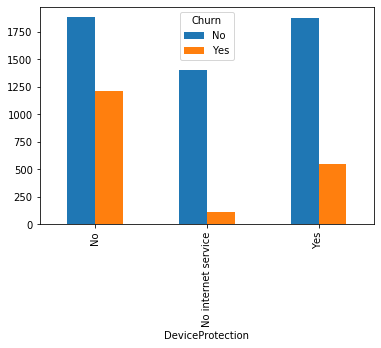

In [21]:
pac.groupby('Churn').DeviceProtection.value_counts().unstack(0).plot.bar()

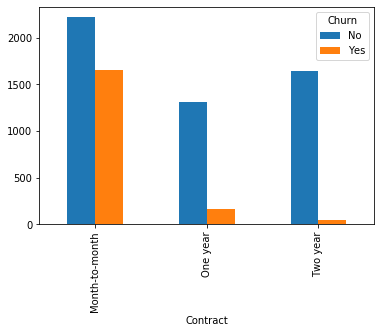

In [22]:
pac.groupby('Churn').Contract.value_counts().unstack(0).plot.bar()

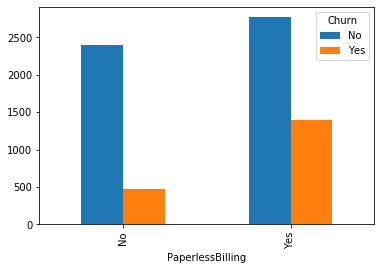

In [23]:
pac.groupby('Churn').PaperlessBilling.value_counts().unstack(0).plot.bar()

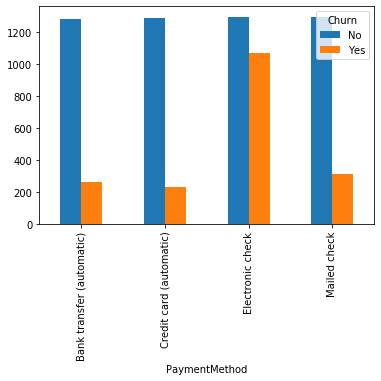

In [24]:
pac.groupby('Churn').PaymentMethod.value_counts().unstack(0).plot.bar()

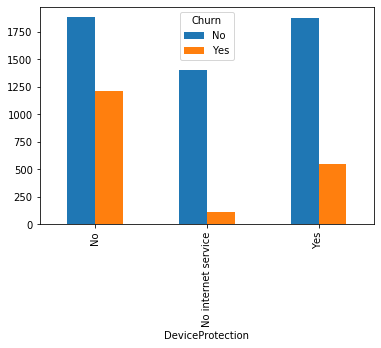

In [25]:
pac.groupby('Churn').DeviceProtection.value_counts().unstack(0).plot.bar()

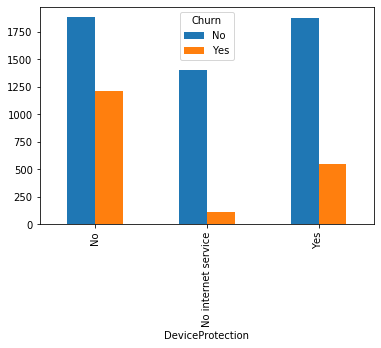

In [26]:
pac.groupby('Churn').DeviceProtection.value_counts().unstack(0).plot.bar()

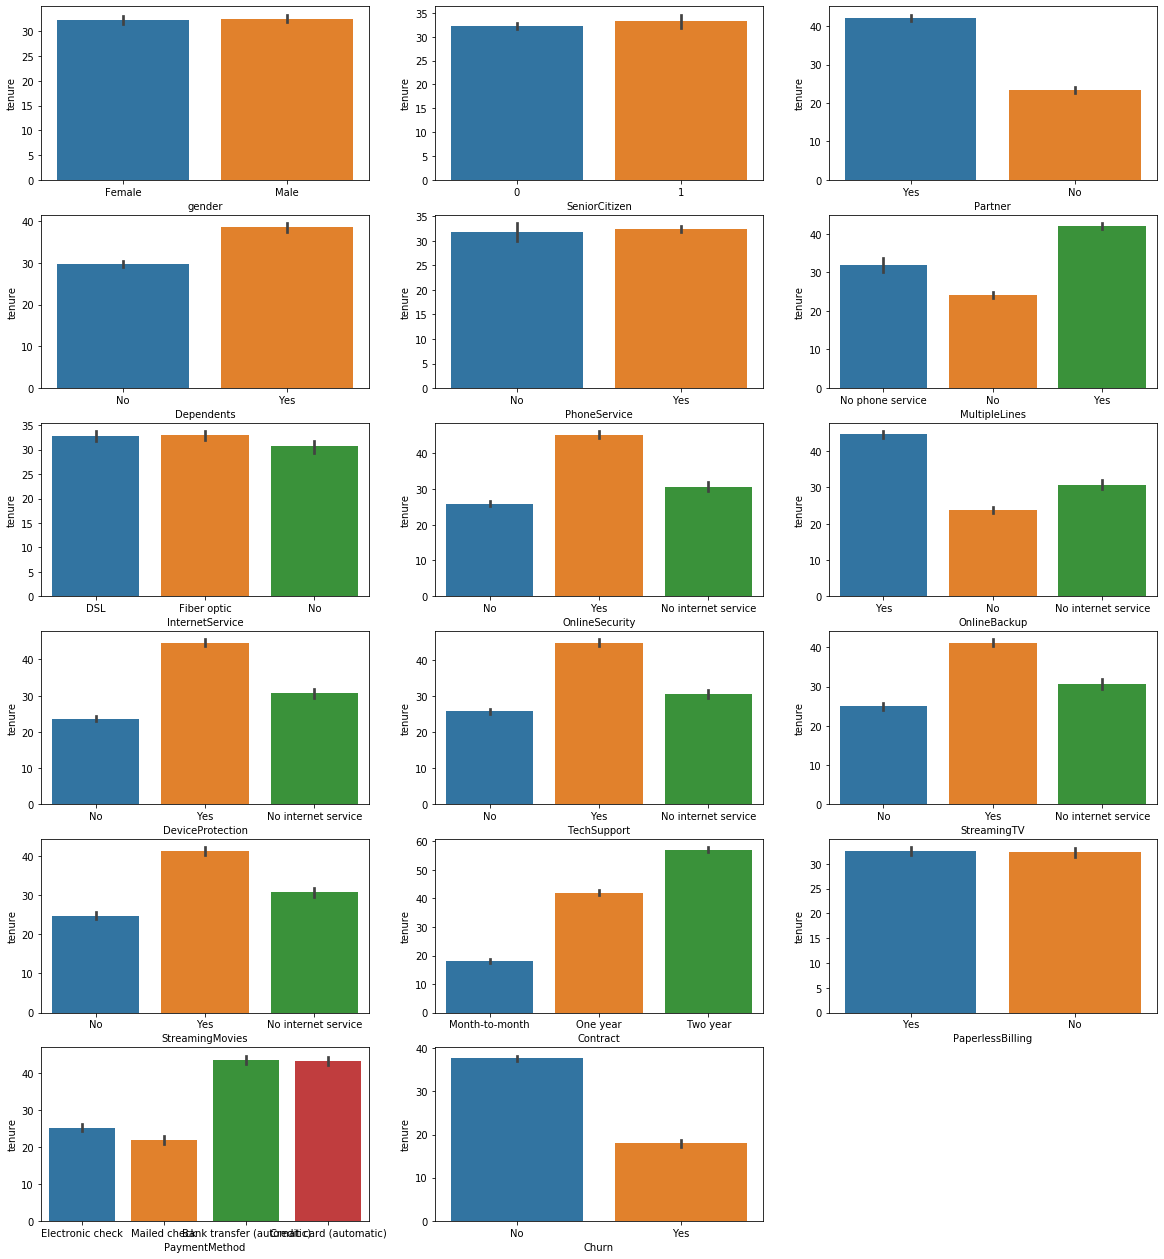

In [27]:
#creating barplot of colums with respect to tenure to check distribution among tenure
count=pac[['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
           'PaymentMethod','Churn','tenure']]
figure(num=None,figsize=(20,30))
for column_index, column in enumerate(count.columns):
    if column == 'tenure':
        continue
    plt.subplot(8, 3, column_index+1)
    
    sns.barplot(y='tenure', x=column, data=count,)

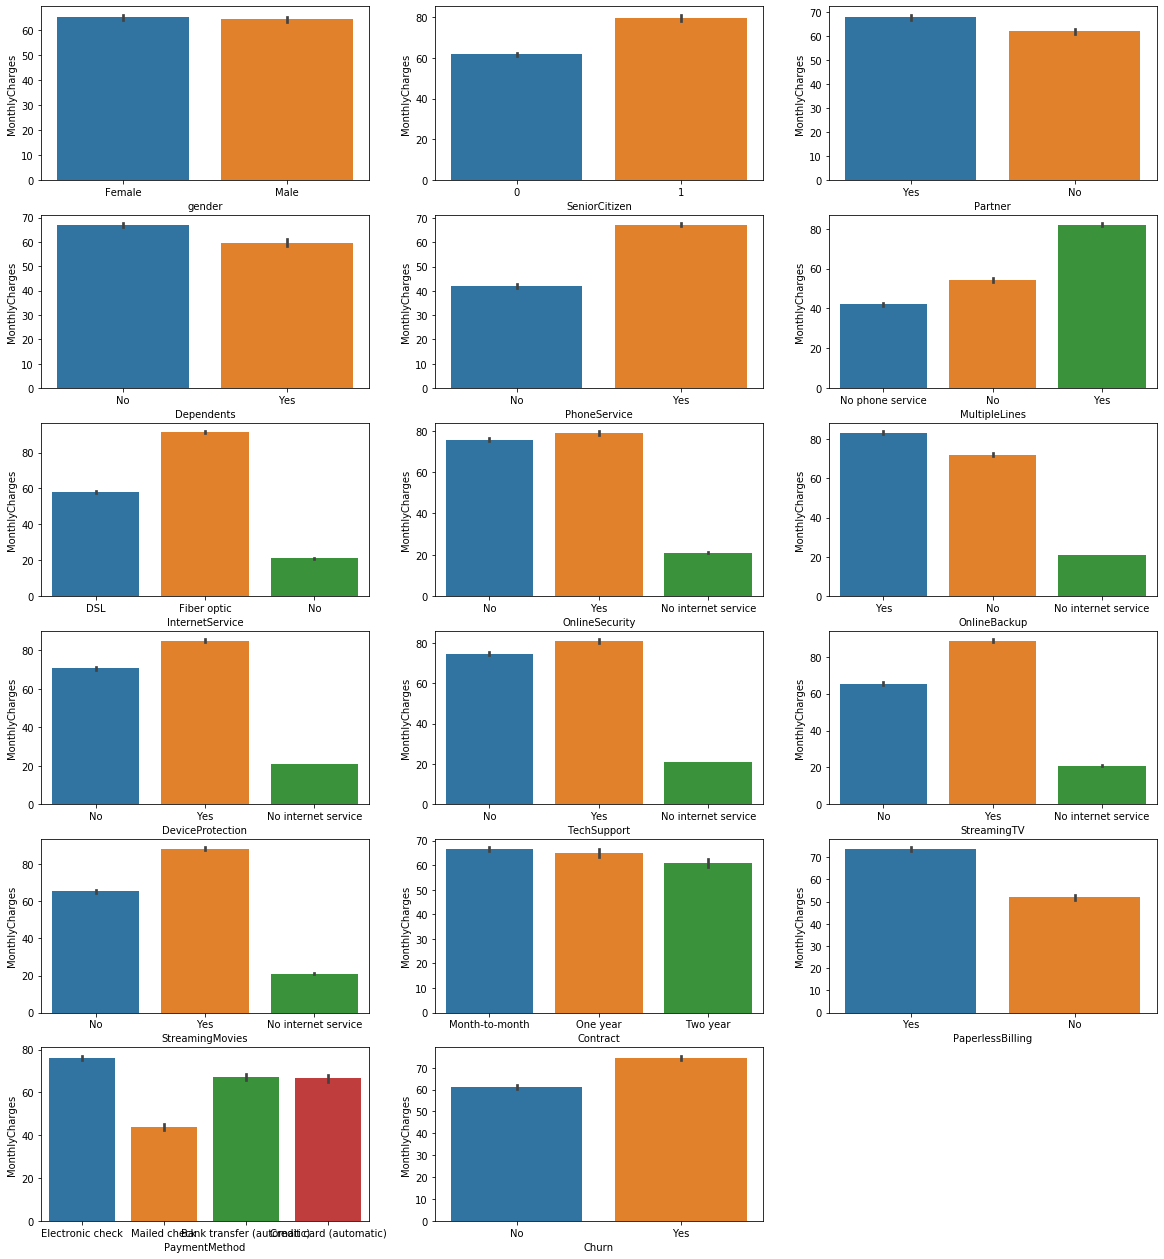

In [28]:
#creating barplot of colums with respect to MonthlyCharges to check distribution among MonthlyCharges
count=pac[['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
           'PaymentMethod','Churn','MonthlyCharges']]
figure(num=None,figsize=(20,30))
for column_index, column in enumerate(count.columns):
    if column == 'MonthlyCharges':
        continue
    plt.subplot(8, 3, column_index+1)
    
    sns.barplot(y='MonthlyCharges', x=column, data=count)

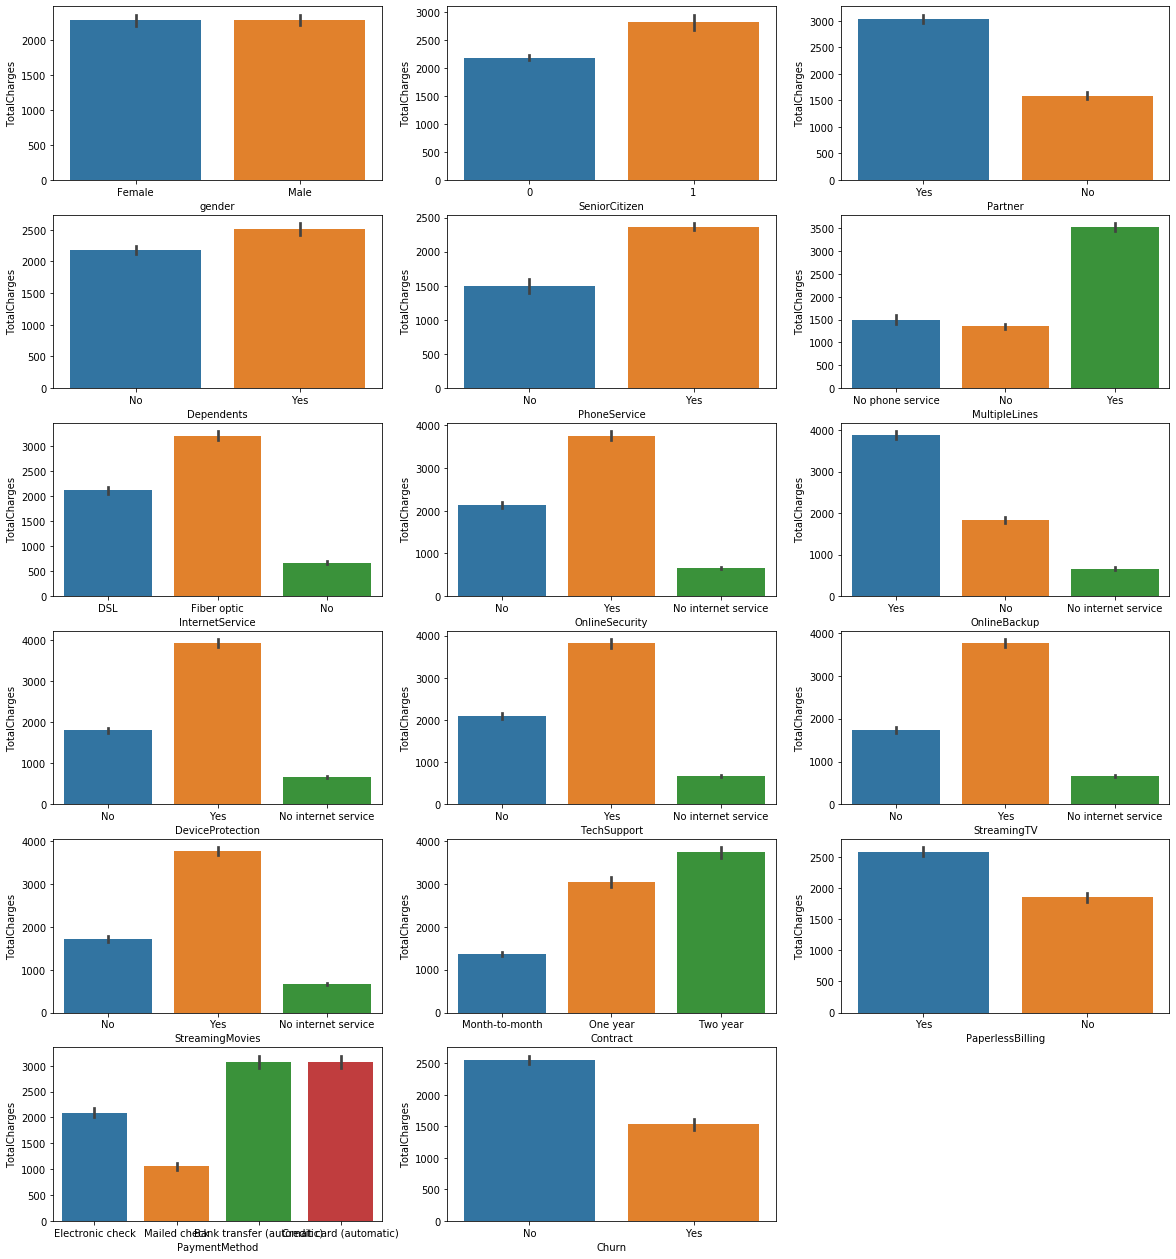

In [29]:
#creating barplot of colums with respect to TotalCharges to check distribution among TotalCharges
count=pac[['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
           'PaymentMethod','Churn','TotalCharges']]
figure(num=None,figsize=(20,30))
for column_index, column in enumerate(count.columns):
    if column == 'TotalCharges':
        continue
    plt.subplot(8, 3, column_index+1)
    
    sns.barplot(y='TotalCharges', x=column, data=count)

SeniorCitizen        AxesSubplot(0.125,0.772143;0.227941x0.107857)
tenure            AxesSubplot(0.398529,0.772143;0.227941x0.107857)
MonthlyCharges    AxesSubplot(0.672059,0.772143;0.227941x0.107857)
TotalCharges         AxesSubplot(0.125,0.642714;0.227941x0.107857)
dtype: object

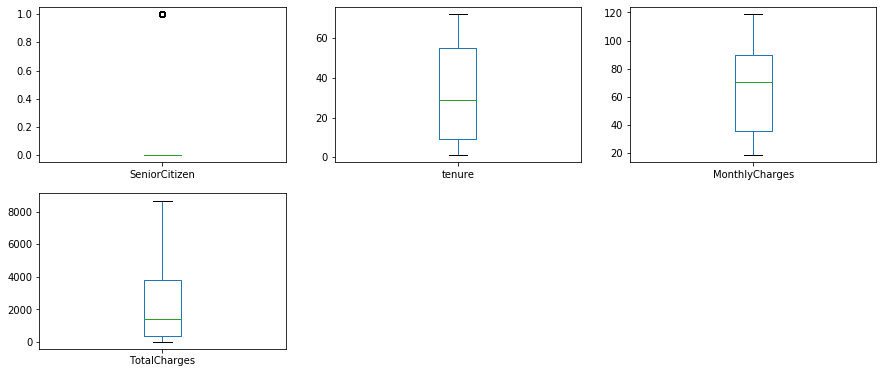

In [30]:
# Creating boxplot of continous variables to visualize the minimum, maximum, avareg value for each colums along with outlires
pac.plot(kind='box',subplots=True,layout=(6,3),figsize=(15,20))

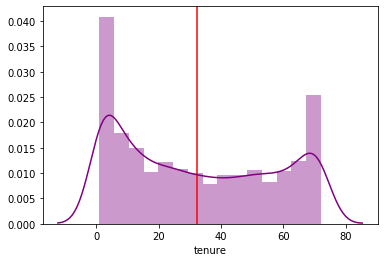

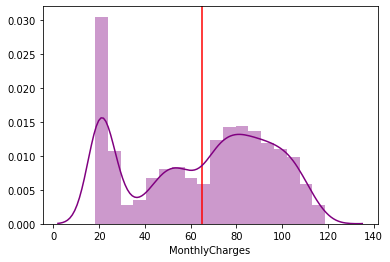

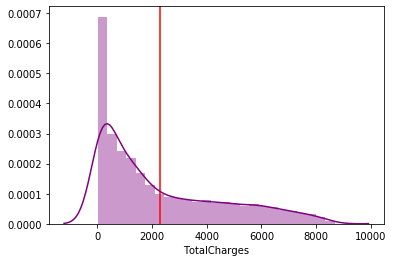

In [31]:
count=pac[['tenure','MonthlyCharges','TotalCharges']]
# Histogram - Distribution plot for all continous variables to visualize skewness
for i,col in enumerate(count):
    plt.figure(i)
    plt.axvline(count[col].mean(),color = 'r')
    sns.distplot(count[col],color='purple')

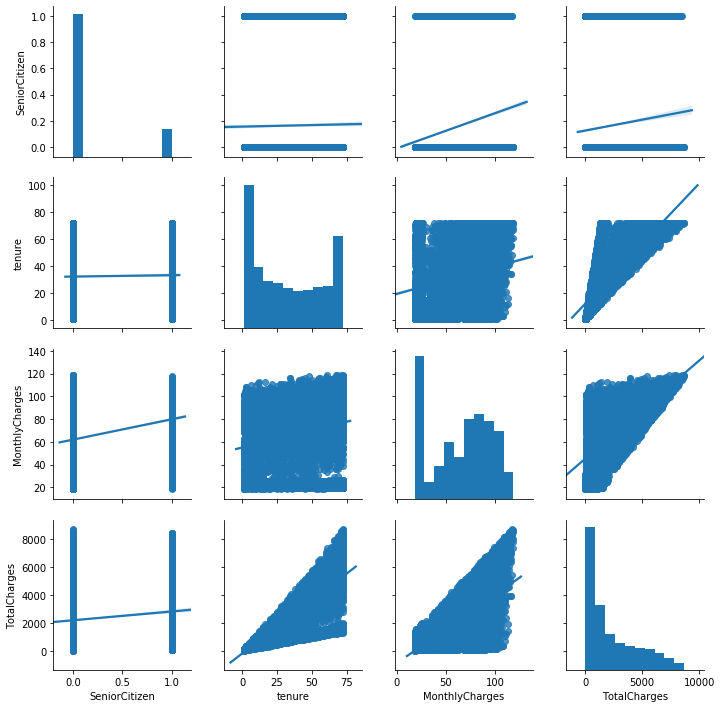

In [32]:
# pair plot to see the scatter of data
sns.pairplot(pac, kind='reg')

###### Manipulating data before bulding the model

In [33]:
#checking skewness
count=pac[['tenure','MonthlyCharges','TotalCharges']]
print('\x1b[1;31m'+'Skewness in data\n'+'\x1b[0m')
print(count.skew())

Skewness in data

tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64


In [34]:
#removing skewness
for col in count.columns:
    if count.skew().loc[col]>0.55:
        pac[col]=np.power(pac[col],1/2)
pac.skew()

SeniorCitizen     1.831103
tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.308926
dtype: float64

In [35]:
#removing outlires 
count=pac[['tenure','MonthlyCharges','TotalCharges']]
z=abs(zscore(count))
print(pac.shape)
pac=pac.loc[(z<3).all(axis=1)]
print(pac.shape)

(7032, 21)
(7032, 21)


In [36]:
#using dummy and label encoding for changing values to numeric form, and dropping irrelevent columns
pac=pac.drop(['customerID'], axis=1)

#masking of object column
categorial_mask=pac.dtypes==object

#categorical columns
categorical_cols=pac.columns[categorial_mask].tolist()

le=LabelEncoder()

pac[categorical_cols]=pac[categorical_cols].apply(lambda col:le.fit_transform(col))

pac.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2841,1,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,2,25.10,8.933085,0
6763,1,1,1,1,71,1,2,0,0,2,2,2,0,2,1,1,0,72.90,71.691352,0
6599,0,0,1,0,13,1,2,1,0,2,2,0,2,0,0,0,2,94.10,34.865456,1
4596,1,0,0,0,18,1,2,1,0,0,2,0,2,0,1,1,1,89.60,40.410395,0
5063,1,0,0,0,21,1,2,1,0,2,0,0,0,0,0,1,2,82.35,43.044744,1


In [37]:
# dividing dataset into input values 'x' and output value 'y'
x = pac.drop(['Churn'],axis=1)
print('x dataset\n',x.head(),'\n')
y=pac['Churn']
print('y datase\n',y.sample(5))
print(x.shape)
print(y.shape)

x dataset
    gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1      

In [38]:
# standardizes the data in x using standerd scaler technique
scale=StandardScaler()
x=scale.fit_transform(x)

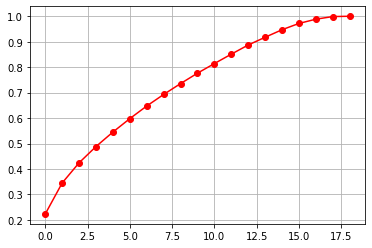

In [39]:
# using pca to find out the variance ratio for dimensionality-reduction
pca=PCA()
train_x1=pca.fit(x)

plt.plot(np.cumsum(pca.explained_variance_ratio_),'ro-')
plt.grid()

we will not use pca for dimensionality-reduction since this does'nt have much effect

###### Bulding and comparing multipe classification model, to find out the best model

In [40]:
#creating models array with all the model
Models=[('SVC',SVC()),('GaussianNB',GaussianNB()),('SGDClassifier',SGDClassifier(random_state=10)),('LogisticRegression',LogisticRegression()),
        ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=10)),('GradientBoostingClassifier',GradientBoostingClassifier()),
        ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis()),('RandomForestClassifier',RandomForestClassifier(random_state=10)),
        ('KNeighborsClassifier',KNeighborsClassifier()),('QuadraticDiscriminantAnalysis',QuadraticDiscriminantAnalysis())]

In [41]:
# loop to find out the maximum ayuray of all the model in models arrac along the range of random state
Model_array=[]
Random_state=[]
Max_accuracy_array=[]
for name,model in Models:
    max_accuracy=0    
    for random_state in range(10,99):
        train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.2,random_state=random_state,stratify=y,shuffle=True)
        model.fit(train_x,train_y)
        pred=model.predict(test_x)
        
        accuracy=accuracy_score(test_y,pred)
        
        if accuracy>max_accuracy:
            max_accuracy=accuracy
            best_random_state=random_state
    
    Model_array.append(name)
    Random_state.append(best_random_state)
    Max_accuracy_array.append(max_accuracy)

In [42]:
# comparing the performances of all the model on accuracy basis
model_accuracy_performance = pd.DataFrame({'Model': Model_array,'Accuracy': Max_accuracy_array,'Random state': Random_state})
model_accuracy_performance.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Random state
3,LogisticRegression,0.828003,52
6,LinearDiscriminantAnalysis,0.822317,41
5,GradientBoostingClassifier,0.819474,35
2,SGDClassifier,0.815920,74
0,SVC,0.811656,81
9,QuadraticDiscriminantAnalysis,0.802416,14
7,RandomForestClassifier,0.800995,77
1,GaussianNB,0.786070,13
8,KNeighborsClassifier,0.772566,44
4,DecisionTreeClassifier,0.751955,76


###### Conclusion
On basis of accuracy LogisticRegression model is performing the best with maximum accuracy score

In [43]:
# loop to find out the cross_val_score of all the model in models array, along a range of random state
Cross_val_score_array=[]
Standard_Deviation=[]
for name, model in Models:
    kf=KFold(n_splits=10,random_state=5)
    cscore=cross_val_score(model,x,y,cv=kf,scoring='accuracy')
    Cross_val_score_array.append(cscore.mean())
    Standard_Deviation.append(cscore.std())

In [44]:
# comparing the performances of all the model on crossval basis
model_cross_val_performance = pd.DataFrame({'Model': Model_array,'Cross val Acuracy': Cross_val_score_array,
                                            'Standard Deviation': Standard_Deviation})
model_cross_val_performance.sort_values(by='Cross val Acuracy', ascending=False)

,Model,Cross val Acuracy,Standard Deviation
5,GradientBoostingClassifier,0.804891,0.015902
3,LogisticRegression,0.804464,0.011885
6,LinearDiscriminantAnalysis,0.800766,0.012855
0,SVC,0.797924,0.011834
2,SGDClassifier,0.795365,0.013579
7,RandomForestClassifier,0.783416,0.013272
9,QuadraticDiscriminantAnalysis,0.771333,0.011998
8,KNeighborsClassifier,0.755541,0.013341
1,GaussianNB,0.754409,0.009987
4,DecisionTreeClassifier,0.736351,0.017523


###### Conclusion
On basis of Cross val Acuracy GradientBoostingRegressor model is performing the best closly follow by LogisticRegression

###### On basis of our compression of Accuracy score and Cross val score i choose LogisticRegression model since it performing best on given data

In [45]:
#using grid search to improve result for GradientBoostingRegressor model
kfoldr =KFold(n_splits=10,random_state=5)
param_grid={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1', 'l2'],'solver':['liblinear', 'saga'],
            'class_weight':[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]}
mod=LogisticRegression()
grid=GridSearchCV(estimator=mod,param_grid=param_grid,scoring='accuracy',cv=kfoldr,n_jobs=-1)
grid_result=grid.fit(x,y)

In [46]:
grid_result.best_score_

0.8046075085324232

In [47]:
grid_result.best_params_

{'C': 0.1,
 'class_weight': {1: 0.5, 0: 0.5},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [48]:
grid_result.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy score of model is :  0.8272921108742004 

The mean of cross_val_score for the model is: 0.8046078898874951 

Precision score of model is : 0.7250859106529209 

Recall score of model is : 0.5641711229946524 

F1_score score of model is : 0.6345864661654136 

Confusion matrix for themodel is : 
 [[953  80]
 [163 211]] 

Classification report for the model is : 
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      1033
           1       0.73      0.56      0.63       374

    accuracy                           0.83      1407
   macro avg       0.79      0.74      0.76      1407
weighted avg       0.82      0.83      0.82      1407
 



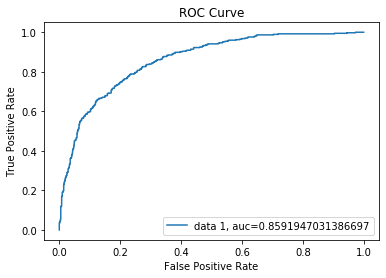

In [49]:
lr=LogisticRegression(C=0.1, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.2,random_state=52,stratify=y,shuffle=True)
lr.fit(train_x,train_y)
pred=lr.predict(test_x)
predict_proba = lr.predict_proba(test_x)[::,1]

kf=KFold(n_splits=10,random_state=5)
cscore=cross_val_score(lr,x,y,cv=kf,scoring='accuracy')

print('Accuracy score of model is : ',accuracy_score(test_y,pred),'\n')
print('The mean of cross_val_score for the model is:',cscore.mean(),'\n')

print('Precision score of model is :',precision_score(test_y, pred),'\n')
print('Recall score of model is :',recall_score(test_y, pred),'\n')
print('F1_score score of model is :',f1_score(test_y, pred),'\n')

print('Confusion matrix for themodel is : \n',confusion_matrix(test_y,pred),'\n')
print('Classification report for the model is : \n',classification_report(test_y,pred),'\n')

fpr, tpr, thresholds  = roc_curve(test_y,  predict_proba)
auc = roc_auc_score(test_y, predict_proba)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label='data 1, auc='+str(auc))
plt.legend(loc=4)
plt.show()

In [50]:
# saving the predection to a csv file.
prediction = pd.DataFrame(pred, columns=['prediction']).to_csv('Project 20 Customer Churn Analysis.csv')

In [51]:
# saving the model using pickle.
joblib.dump(lr,'lr_Project 20 Customer Churn Analysis.pkl')

['lr_Project 20 Customer Churn Analysis.pkl']